# Example 

This notebook will show how to train a GAT model using the community detection task. We will generate the LFR benchmark graph and train the GAT model on it. Then, we will generate the node embeddings using the trained model and visualize the embeddings using the PCA.


In [1]:
import numpy as np
import gnn_tools
import networkx as nx

In [2]:
# Generate an LFR benchmark graph using networkx
# Disclaimer: The LFR benchmark graph generated by the networkx is not the same as the one used in the original paper.
# We will use the networkx implementation for demonstration purposes only.
# It is recommended to use the original implementation of the LFR benchmark graph for research purposes.
# A python wrapper for the original implementation can be found at https://github.com/skojaku/LFR-benchmark
import networkx as nx

# Parameters for the LFR benchmark graph
num_nodes = 1000
tau1 = 3
tau2 = 1.5
mu = 0.2
average_degree = 50
min_community = 100
max_community = 500
min_degree = 10
max_degree = 50

# Generate the graph
G_lfr = nx.generators.community.LFR_benchmark_graph(
    n=num_nodes,
    tau1=tau1,
    tau2=tau2,
    mu=mu,
    min_degree=min_degree,
    max_degree=max_degree,
    # average_degree=average_degree,
    min_community=min_community,
    max_community=max_community,
    seed=42,
)

# Extract the ground truth communities
communities = {frozenset(G_lfr.nodes[v]["community"]) for v in G_lfr}
labels = np.zeros(num_nodes)
for i, com in enumerate(communities):
    labels[np.array(list(com))] = i

net = nx.to_scipy_sparse_array(G_lfr)

# Print information about the graph
print(
    f"Generated LFR benchmark graph with {G_lfr.number_of_nodes()} nodes and {G_lfr.number_of_edges()} edges."
)
print(f"Number of communities: {len(set(communities))}")

Generated LFR benchmark graph with 1000 nodes and 10117 edges.
Number of communities: 6


In [6]:
emb = gnn_tools.GAT(
    net, dim=128, epochs=500, lr=1e-2, memberships=labels, device="cuda:1"
)

loss=1.028 iter/epoch=3:   6%|▋         | 32/500 [00:01<00:13, 34.25it/s]

loss=0.091 iter/epoch=3: 100%|██████████| 500/500 [00:15<00:00, 32.66it/s]


<Axes: >

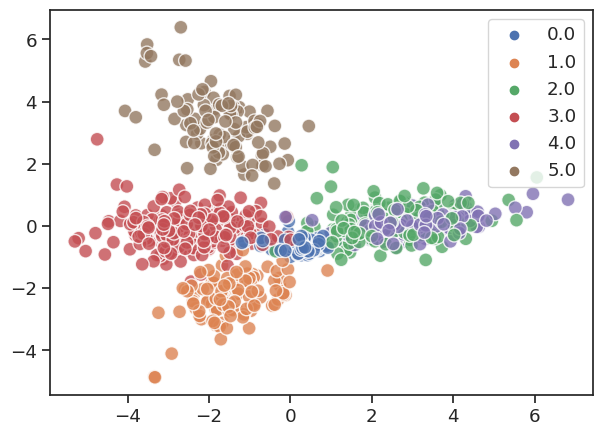

In [8]:
from sklearn.decomposition import PCA

xy = PCA(n_components=2).fit_transform(emb)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7, 5))

sns.scatterplot(
    x=xy[:, 0],
    y=xy[:, 1],
    hue=labels,
    palette="deep",
    s=100,
    alpha=0.8,
    linewidth=1.0,
    ax=ax,
)

In [9]:
# Community detection
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

kmeans = KMeans(n_clusters=len(set(labels)), random_state=0).fit(emb)
kmeans_labels = kmeans.labels_

nmi = normalized_mutual_info_score(labels, kmeans_labels)
print(f"NMI: {nmi}")

NMI: 0.8101885648368067


/home/skojaku/anaconda3/envs/linkpred/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
